# 確率ロボティクス2017第12回

上田隆一

2017年12月6日@千葉工業大学

## 今日やること

* SLAMとは何か
* FastSLAM

## SLAM

* SLAM（simultaneous localization and mapping）
  * 自己位置推定と地図生成を同時に行う方法
 

## SLAM問題

* 次のような地図$m^*$を求める問題
  * $m^* = \text{argmax}_m P(m |x_{0:t}, u_{1:t}, z_{1:t})$
    * $x_{0:t}$: 行動のシーケンス$（x_0,x_1,x_2,...,x_t）$
    * $u_{1:t}$: センサ情報のシーケンス$（u_1,u_2,u_3,...,u_t）$
    * $z_{1:t}$: センサ情報のシーケンス$（z_1,z_2,z_3,...,z_t）$
      * （面倒なのでベクトルも細字で書いてます） 

## SLAMの基本手続き

* これで地図ができる （2次元の例, 距離センサを想定）
  * 最初のロボットの位置$x_0$（絶対座標）を$ (x,y,\theta) = (0,0,0)$とする
  * 以下の繰り返し
    * センサで障害物の位置を計測
    * 障害物の位置を絶対座標に変換して記録
    * ロボットを動かしてロボットの座標を更新
* 問題
  * 移動誤差、センサの雑音


## 確率を使わない実装

* 日経Linux 2015年11月号の上田の記事より

<img width="300" src="env.png" />
<img width="300" src="map-300x300.png" />

## 誤差への対応

* ベイズフィルタ
  * 主にオンラインSLAMで利用される
* 最小二乗法
  * 主にオフラインSLAMで利用される
* オンライン/オフライン
  * オンライン: ロボットが自己位置と地図を動いている途中に特定していく
  * オフライン: デッドレコニングとセンサ情報を全て記録しておいて後から地図と移動軌跡を特定

## FastSLAM

* オンラインSLAMの代表的な手法
* MCL + 地図の推定
* 1.0と2.0がある
  * 1.0をこれから実装
    * MCLのコードをコピーしながら作っていきましょう

### ランドマークの準備

In [1]:
%matplotlib inline
import numpy as np
from copy import copy
import math, random
import matplotlib.pyplot as plt                   #   for plotting data
from matplotlib.patches import Ellipse      #  for drawing

actual_landmarks = [np.array([-0.5,0.0]),np.array([0.5,0.0]),np.array([0.0,0.5])]

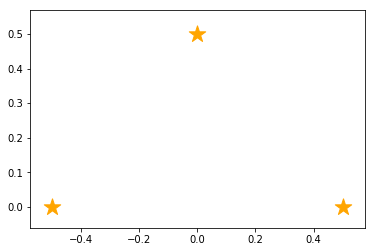

In [2]:
def draw_landmarks(landmarks):
    xs = [ e[0] for e in landmarks]
    ys = [ e[1] for e in landmarks]
    plt.scatter(xs,ys,s=300,marker="*",label="landmarks",color="orange")
    
draw_landmarks(actual_landmarks)

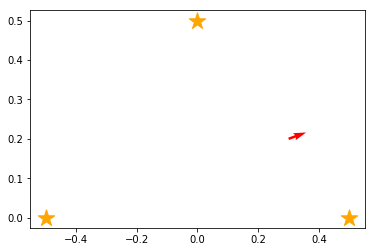

In [3]:
class Robot:
    def __init__(self,pose):
        self.pose = pose
        
    def draw(self):
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
robot = Robot(np.array([0.3,0.2,math.pi*20.0/180]) )
robot.draw()
draw_landmarks(actual_landmarks)

In [4]:
def relative_landmark_pos(pose,landmark,i):
    x,y,theta = pose
    lx,ly = landmark
    distance = math.sqrt((x -lx)**2 + (y-ly)**2)
    direction = math.atan2(ly-y, lx-x) - theta
    
    return (distance, direction,lx,ly,i) # 実際の位置とIDも一緒に返す

In [5]:
measurements = [ relative_landmark_pos(robot.pose,e,i) for i,e in enumerate(actual_landmarks)]
print(measurements)

def draw_observation(pose,  measurement):
    x,y,theta = pose
    distance, direction,lx,ly, i = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
def draw_observations(pose, measurements):
    for m in measurements:
        draw_observation(pose, m)

[(0.8246211251235323, -3.2456798408617948, -0.5, 0.0, 0), (0.28284271247461906, -1.1344640137963142, 0.5, 0.0, 1), (0.4242640687119285, 2.0071286397934789, 0.0, 0.5, 2)]


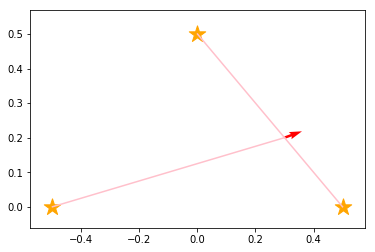

In [6]:
draw_landmarks(actual_landmarks)
robot.draw()
draw_observations(robot.pose,measurements)

### ランドマーク観測に誤差の情報を入れる

* 正規分布に従うノイズを混入させる
  * 観測した方向に距離の10%のノイズ
  * 観測した方向と垂直な方向に$距離\times\sin(5[\text{deg}])$のノイズ

In [7]:
def observation(pose, landmark, i):
    actual_distance,actual_direction,lx,ly,i = relative_landmark_pos(pose,landmark,i)
    # 方向の制限（cosの値が正）
    if (math.cos(actual_direction) < 0.0):
        return None
    
    measured_distance = random.gauss(actual_distance,actual_distance*0.1)  
    measured_direction = random.gauss(actual_direction,5.0/180.0*math.pi)
    
    return (measured_distance, measured_direction,lx,ly,i)

def observations(pose,landmarks):
    return filter(lambda x: x != None, [ observation(pose,e,i) for i,e in enumerate(landmarks)])

def ellipse(x,y,cov):
    eigen = np.linalg.eig(cov)
    v1 = eigen[0][0] * eigen[1][0]
    v2 = eigen[0][1] * eigen[1][1]
    v1_direction = math.atan2(v1[1],v1[0])
    
    elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
    elli.set_alpha(0.2)
    return elli 

# draw_observationを上書き
def draw_observation(pose,  measurement,sp):
    x,y,theta = pose
    distance, direction,lx,ly,i = measurement
    lx = distance*math.cos(theta + direction) + x
    ly = distance*math.sin(theta + direction) + y
    plt.plot([pose[0],  lx],[pose[1],  ly],color="pink")
    
    ## 誤差のガウス分布を作る
    c = math.cos(theta + direction)
    s = math.sin(theta + direction)
    rot = np.array([[  c,s],
                    [-s,c]])
    
    err_robot = np.array([[(distance*0.1)**2,0.0],
                        [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
    err_world = (rot).dot(err_robot).dot((rot).T)
    sp.add_artist(ellipse(lx,ly,err_world))
    
def draw_observations(pose, measurements,sp):
    for m in measurements:
        draw_observation(pose, m, sp)

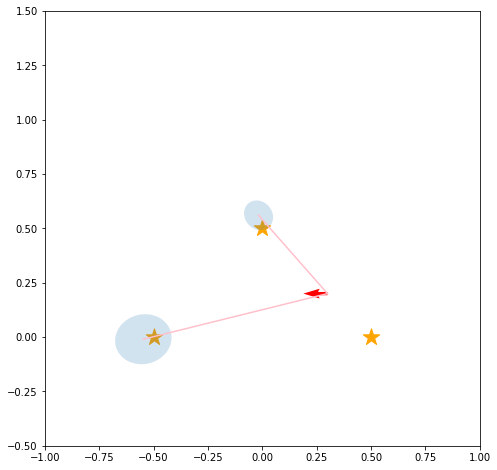

In [8]:
robot.pose = np.array([0.3,0.2,math.pi*180.0/180])   #姿勢は変えること
measurements = observations(robot.pose, actual_landmarks)

def draw(i):
    fig = plt.figure(i,figsize=(8, 8))
    sp = fig.add_subplot(111, aspect='equal')
    sp.set_xlim(-1.0,1.0)
    sp.set_ylim(-0.5,1.5)

    draw_landmarks(actual_landmarks)
    robot.draw()
    draw_observations(robot.pose, measurements,sp)
    
draw(1)

## ロボットの歩行モデル

In [9]:
def motion(pos, fw, rot):
    actual_fw = random.gauss(fw,fw/10)    #標準偏差にしてfwの10%だけ移動距離に雑音を入れる
    dir_error = random.gauss(0.0, math.pi / 180.0 * 3.0) # 前進時にロボットの進路が曲がる雑音。標準偏差3[deg] 
        
    px, py, pt = pos
        
    #前進させる
    x = px + actual_fw * math.cos(pt + dir_error)
    y = py + actual_fw * math.sin(pt + dir_error)
        
    #回転。回転角にもrotの10%だけ雑音を入れる
    t = pt + dir_error + random.gauss(rot,rot/10)
        
    return np.array([x,y,t])

## FastSLAMの実装

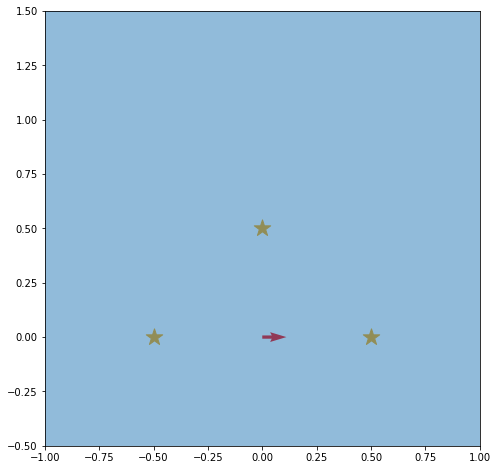

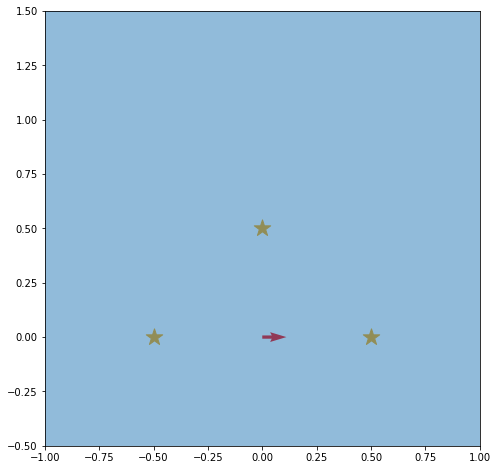

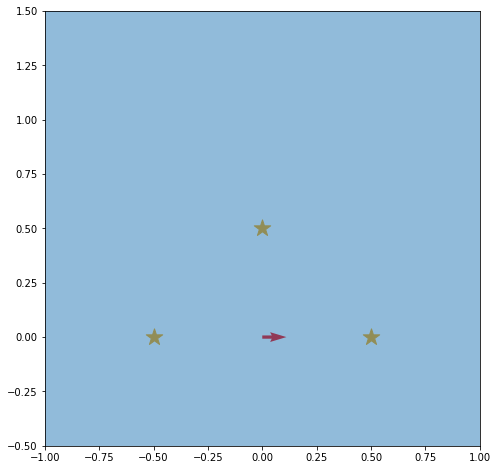

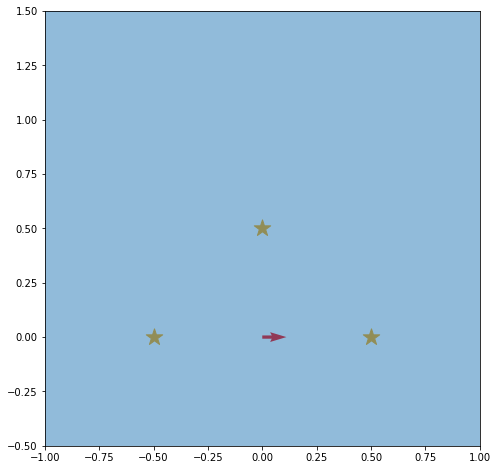

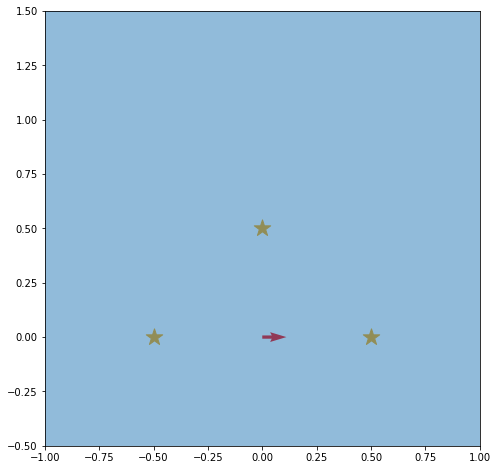

In [10]:
class LandmarkEstimation():
    def __init__(self):
        self.pos = np.array([[0.0],[0.0]])
        self.cov = np.array([[1000000000.0**2,0.0],
                            [0.0,1000000000.0**2]])

class Particle():
    def __init__(self,pose,w):
        self.w = w
        self.pose = pose
        self.map = [LandmarkEstimation(),LandmarkEstimation(),LandmarkEstimation()]
        
    def motion_update(self, fw, rot):
        self.pose = motion(self.pose, fw, rot)
        
    def measurement_update(self, measurement):
        x,y,theta = self.pose
        distance, direction,lx,ly,i = measurement
        ln = self.map[i]
        lx = distance*math.cos(theta + direction) + x
        ly = distance*math.sin(theta + direction) + y
        ## 重みの更新
        delta = np.array([[x],[y]]) - np.array([[lx],[ly]])
        coef = 2*math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T.dot(np.linalg.inv(ln.cov))).dot(delta)
        self.w *= 1.0/coef * math.exp(inexp)
        
        ## 地図の書き換え
        
        z = np.array([[lx],[ly]])
    
        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[  c,s],
                        [-s,c]])
    
        err_robot = np.array([[(distance*0.1)**2,0.0],
                            [0.0,(distance*math.sin(5.0/180.0*math.pi))**2]])
        err_world = (rot).dot(err_robot).dot((rot).T)       
        
        ln.cov = np.linalg.inv( np.linalg.inv(ln.cov) + np.linalg.inv(err_world) )
        K = (ln.cov).dot(np.linalg.inv(err_world))
        ln.pos += K.dot( z - ln.pos )
        
    def draw(self,i):
        fig = plt.figure(i,figsize=(8, 8))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        draw_landmarks(actual_landmarks)
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
        es = [ellipse(e.pos[0],e.pos[1],e.cov) for e in self.map]
        for e in es:
            sp.add_artist(e)

import copy
        
class FastSLAM():
    def __init__(self,pose):
        self.particles = [Particle(pose,1.0/100) for i in range(100)]
        
    def draw(self):
        for (i,p) in enumerate(self.particles):
            p.draw(i)
            if i > 3: return
            
    def motion_update(self, fw, rot):
        for p in self.particles:
            p.motion_update(fw,rot)
            
    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)
            
        self.resampling()
            
    def resampling(self):
        num = len(self.particles)                # numはパーティクルの個数
        ws = [e.w for e in self.particles]    # 重みのリストを作る
    
        if sum(ws) < 1e-100:                     #重みの和がゼロに丸め込まれるとサンプリングできなくなるので小さな数を足しておく
            ws = [e + 1e-100 for e in ws]
            
        ps = random.choices(self.particles, weights=ws, k=num)    # パーティクルのリストから、weightsのリストの重みに比例した確率で、num個選ぶ
        self.particles = [copy.deepcopy(e) for e in ps]          # 選んだリストからパーティクルを取り出し、パーティクルの姿勢から重み1/numの新しいパーティクルを作成
        
robot.pose = np.array([0.0,0.0,0.0])   #ロボットの実際の姿勢
slam = FastSLAM(robot.pose)
slam.draw()

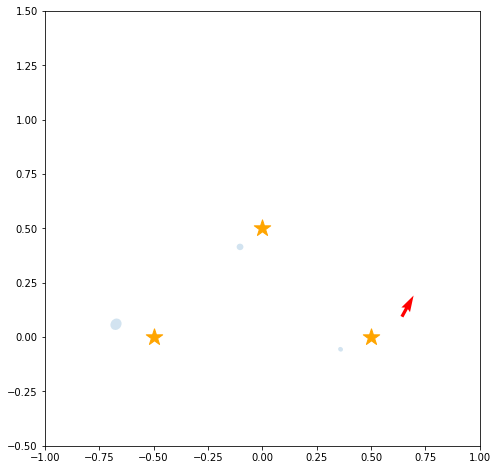

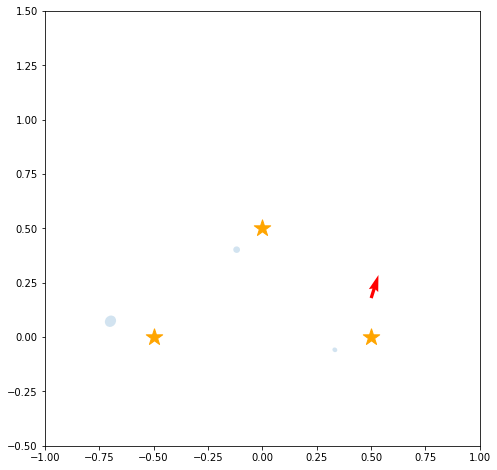

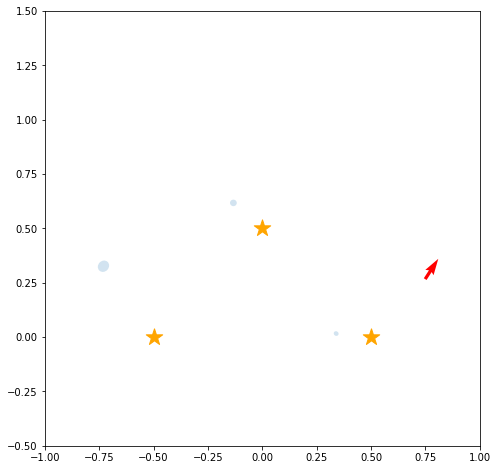

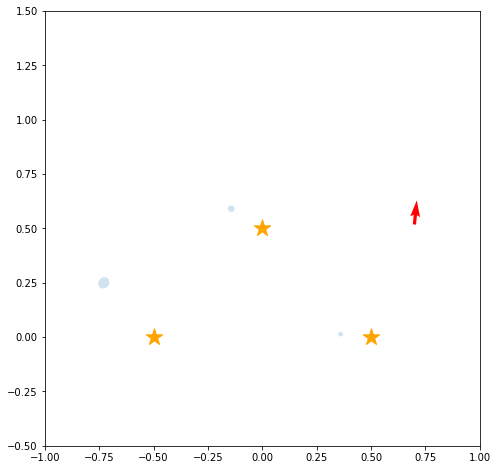

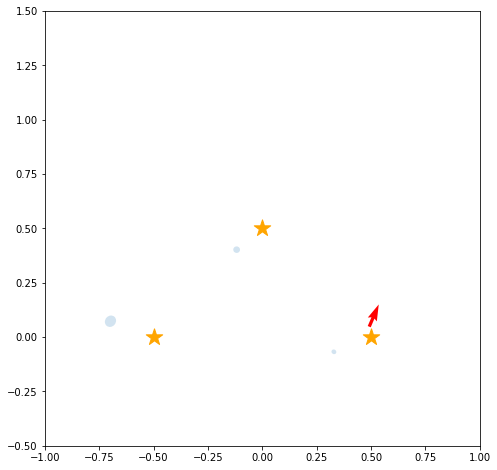

In [11]:
def one_step():
    slam.motion_update(0.2, math.pi / 180.0 * 20)
    robot.pose = motion(robot.pose, 0.2, math.pi / 180.0 * 20)
    measurements = observations(robot.pose, actual_landmarks)
    for m in measurements:
        slam.measurement_update(m)
    
for i in range(40):
    one_step()

slam.draw()

    
